In [15]:
import numpy as np
import os
import sys
from fractions import gcd
from numbers import Number

import torch
from torch import Tensor, nn
from torch.nn import functional as F

from data import ArgoDataset, collate_fn
from utils import gpu, to_long,  Optimizer, StepLR

from layers import Conv1d, Res1d, Linear, LinearRes, Null
from numpy import float64, ndarray
from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union

from lanegcn import PredNet, get_model
import torch
from torch.utils.data import Sampler, DataLoader

import matplotlib.pyplot as plt



In [380]:
config, Dataset, collate_fn, net, loss, post_process, opt = get_model()
import os

import argparse
import numpy as np
import random
import sys
import time
import shutil
from importlib import import_module
from numbers import Number

import torch
from torch.utils.data import Sampler, DataLoader


from utils import Logger, load_pretrain
def worker_init_fn(pid):
    np_seed = int(pid)
    np.random.seed(np_seed)
    random_seed = np.random.randint(2 ** 32 - 1)
    random.seed(random_seed)


dataset = Dataset(config["train_split"], config, train=True)
train_loader = DataLoader(
    dataset,
    batch_size=config["batch_size"],
    num_workers=config["workers"],
    shuffle=False,
    collate_fn=collate_fn,
    pin_memory=True,
    worker_init_fn=worker_init_fn,
    drop_last=True,
)


for i, data in enumerate(train_loader):
    break


In [381]:
data.keys()

dict_keys(['city', 'orig', 'gt_preds', 'has_preds', 'theta', 'rot', 'feats', 'ctrs', 'graph', 'trajs2', 'traj1'])

In [382]:
trajs2 = data['trajs2'][0]
print(len(data['trajs2']))
print(trajs2.size())
print(data['trajs2'][0][0].size())
print(data['trajs2'][0][0][1]-data['trajs2'][0][0][0])
print(data['trajs2'][0][0][:,2].sum())

32
torch.Size([6, 50, 3])
torch.Size([50, 3])
tensor([ 1.6808, -0.0800,  0.0000])
tensor(50.)


In [383]:
# def del_tensor_ele(tensor, index):
#     tensor1 = tensor[0:index]
#     tensor2 = tensor[index+1:]
#     return torch.cat((tensor1, tensor2), dim=0)

for i in range(len(data['trajs2'])):
    trajs2_list = []
    for j in range(len(data['trajs2'][i])):
        trajs_raw = data['trajs2'][i][j]
        flag_sum = trajs_raw[:,2].sum()
        # print(i,j)
        if flag_sum == 50:
            trajs2_list.append(trajs_raw.unsqueeze(1))
    data['trajs2'][i] = torch.cat(trajs2_list, dim=1).permute(1,0,2)

            

In [384]:
data['trajs2'][0].size()

torch.Size([5, 50, 3])

In [385]:
lane = data['graph'][0]['ctrs']

In [386]:
import seaborn as sns
sns.set()
plt.rcParams['figure.figsize'] = (12,12)

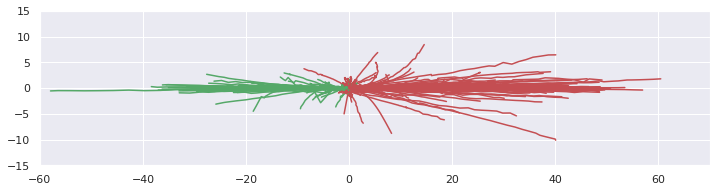

In [407]:
trajectory_set = []
for j in range(len(data['graph'])):
    lane = data['graph'][j]['ctrs']
    trajs2 = data['trajs2'][j].clone()

    # plt.scatter(lane[:,0],lane[:,1],marker='.',s=1)

    for i in range(len(trajs2)):
        orig = trajs2[i][19]
        pre = trajs2[i][15] - orig
        theta = np.pi - np.arctan2(pre[1], pre[0])
        rot = np.asarray([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]], np.float32)
        trajs2[i][:,:2] = np.matmul(rot, (trajs2[i] - orig)[:,:2].T).T
        trajs2[i][:, 2] = 1.0

        trajectory_set.append(trajs2[i][:,:2])

        plt.gca().set_aspect(1)
        plt.xlim(-60,70)
        plt.ylim(-15,15)

        plt.plot(trajs2[i][:20,0], trajs2[i][:20,1],color='g')
        plt.plot(trajs2[i][20:,0], trajs2[i][20:,1],color='r')
    # break

# plt.plot(trajs2[3][:,0], trajs2[3][:,1])

# plt.savefig('./map.eps')


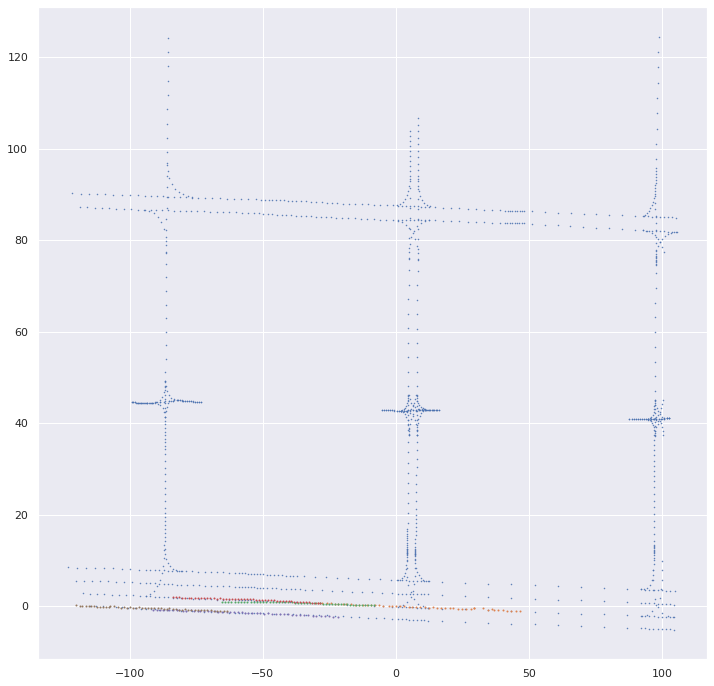

In [393]:
j = 0
lane = data['graph'][j]['ctrs']
trajs2 = data['trajs2'][j].clone()

plt.scatter(lane[:,0],lane[:,1],marker='.',s=1)

for i in range(len(trajs2)):  # i: 0-9
    plt.scatter(trajs2[i][:50,0], trajs2[i][:50,1],s=1)

# plt.savefig('./map.eps')

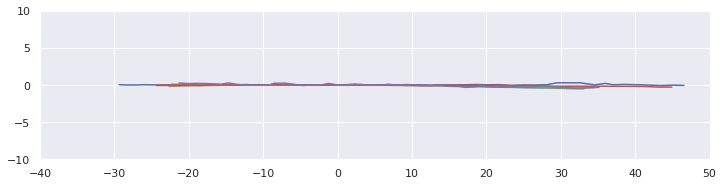

In [403]:
j = 0
lane = data['graph'][j]['ctrs']
trajs2 = data['trajs2'][j].clone()

# plt.scatter(lane[:,0],lane[:,1],marker='.',s=1)

for i in range(len(trajs2)):  # i: 0-9
    # trajectory_set.append(trajs2[i][:,:2])

    orig = trajs2[i][19]
    pre = trajs2[i][10] - orig
    theta = np.pi - np.arctan2(pre[1], pre[0])
    rot = np.asarray([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]], np.float32)
    # print((trajs2[i] - orig)[:,:2])
    # print(rot)
    trajs2[i][:,:2] = np.matmul(rot, (trajs2[i] - orig)[:,:2].T).T
    trajs2[i][:, 2] = 1.0
    # print(trajs2[i])
    plt.gca().set_aspect(1)
    plt.xlim(-40,50)
    plt.ylim(-10,10)
    plt.plot(trajs2[i][:50,0], trajs2[i][:50,1])

plt.savefig('./map.eps')

MovieWriter imagemagick unavailable; using Pillow instead.


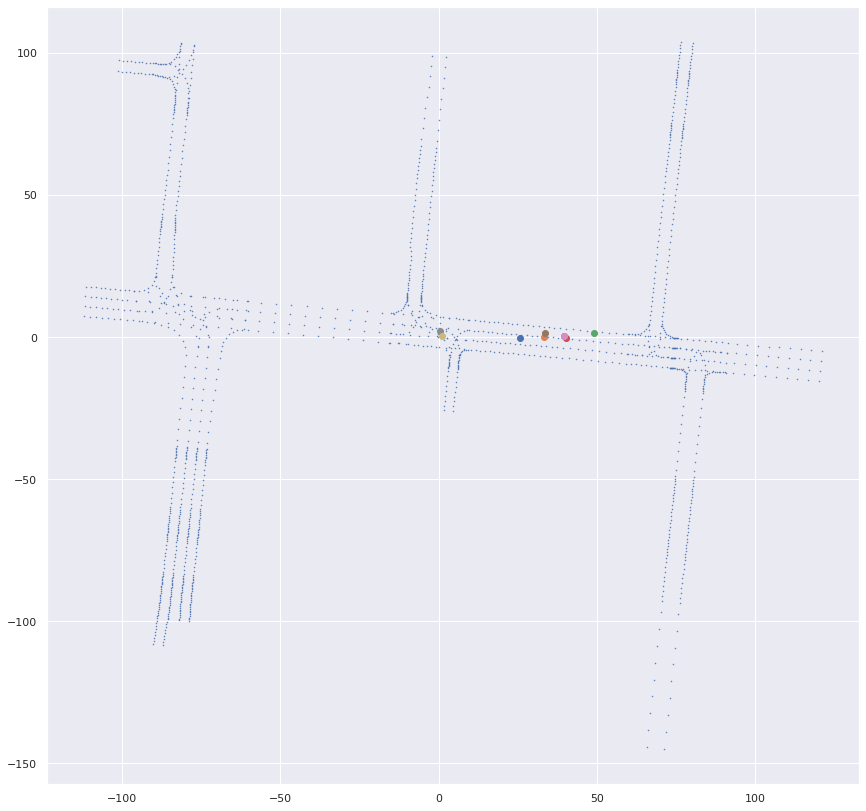

In [408]:
import matplotlib.animation as animation

fig = plt.figure()
ax = fig.add_axes([0.03, 0.05, 0.94, 0.9])
ax.scatter(lane[:,0],lane[:,1],marker='.',s=1)

lines = []
for i in range(len(trajs2)):
    line, = ax.plot([], [],'o')
    lines.append(line)


index = 0

def update_plot(*arg):
    global index
    # print(index)

    for i in range(len(trajs2)):
        lines[i].set_data(trajs2[i,index,0], trajs2[i,index,1])
    index += 1

    return lines

ani = animation.FuncAnimation(fig, update_plot, interval=100, save_count=48, blit=True, repeat=False)

ani.save('./gif/animation.gif', writer='imagemagick')
plt.show()

In [409]:
trajectory_set[0].size()

torch.Size([50, 2])

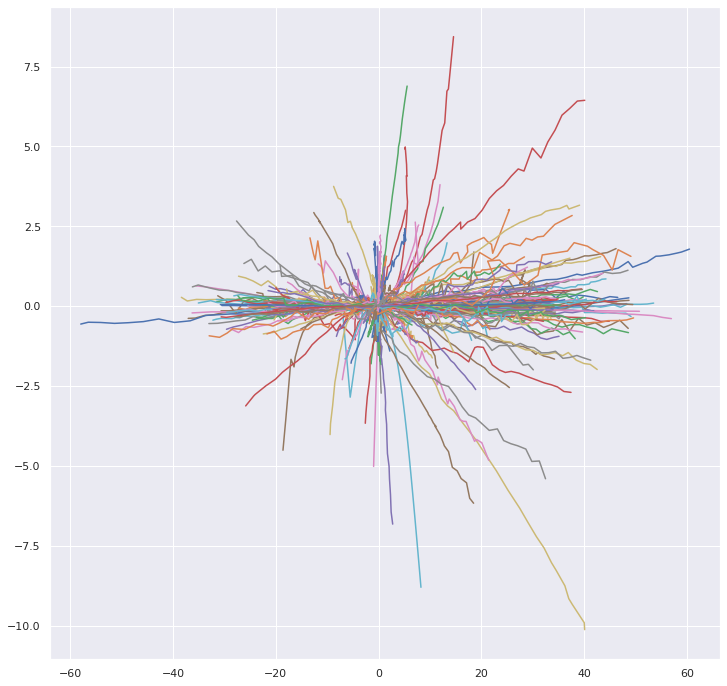

In [410]:
for traj in trajectory_set:
    plt.plot(traj[:,0],traj[:,1])

In [411]:
import math

In [412]:
degree_threshold = 5

for traj_index, traj in enumerate(trajectory_set):
    hold_index_lst = []
    previous_azimuth = 1000

    for point_index, point in enumerate(traj[:-1]):
        next_point = traj[point_index + 1]
        diff_vector = next_point - point 
        azimuth = (math.degrees(math.atan2(*diff_vector) + 360) % 360)

        if abs(azimuth - previous_azimuth) > degree_threshold:
            hold_index_lst.append(point_index)
            previous_azimuth = azimuth

    hold_index_lst.append(traj.shape[0] - 1)

    trajectory_set[traj_index] = traj[hold_index_lst, :]

In [413]:
from scipy.spatial.distance import directed_hausdorff 

def hausdorff(u,v):
    d = max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])
    return d

traj_count = len(trajectory_set)
D = np.zeros((traj_count, traj_count))

for i in range(traj_count):
    for j in range(i+1, traj_count):
        distance = hausdorff(trajectory_set[i], trajectory_set[j])
        D[i, j] = distance
        D[j, i] = distance


In [414]:
def kMedoids(D, k, tmax=100):
    # determine dimensions of distance martrix D
    m, n = D.shape

    np.fill_diagonal(D, math.inf)

    M = np.arange(n)
    np.random.shuffle(M)
    M = np.sort(M[:k])

    Mnew = np.copy(M)

    C = {}

    for t in range(tmax):
        J = np.argmin(D[:,M], axis=1)

        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]

        for kappa in range(k):
            J = np.mean(D[np.ix_(C[kappa], C[kappa])], axis=1)
            j = np.argmin(J)
            Mnew[kappa] = C[kappa][j]

        np.sort(Mnew)

        if np.array_equal(M, Mnew):
            break
        M = np.copy(Mnew)

    else:
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]

    np.fill_diagonal(D, 0)

    return M, C

In [492]:
from sklearn.cluster import DBSCAN

k = 4
method_center_lst, cluster2index_lst = kMedoids(D, k)

In [493]:
color_lst = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_lst.extend(['firebrick', 'olive', 'indigo', 'khaki', 'teal', 'saddlebrown',
                  'skyblue', 'coral', 'darkorange', 'lime', 'darkkorchid', 'dimgray'])

def plot_cluster(trajectory_set, cluster_lst):

    cluster_count = np.max(cluster_lst) + 1
    plt.gca().set_aspect(1)
    plt.xlim(-40,50)
    plt.ylim(-10,10)
    for traj, cluster in zip(trajectory_set, cluster_lst):
        if cluster == -1:
            plt.plot(traj[:,0], traj[:,1], c='k', linestyle='dashed')
        else:
            plt.plot(traj[:,0], traj[:,1], c=color_lst[cluster % len(color_lst)])
    # plt.savefig('./cluster.eps')
    plt.show()

In [494]:
len(trajectory_set)

278

In [495]:
cluster_lst.shape

(278,)

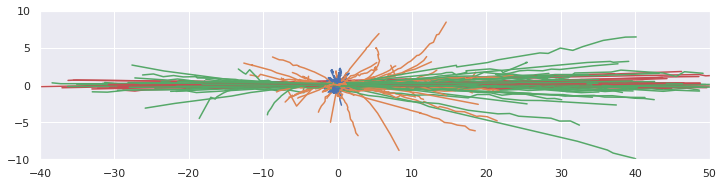

In [496]:
cluster_lst = np.empty((traj_count), dtype=int)

for cluster in cluster2index_lst:
    cluster_lst[cluster2index_lst[cluster]] = cluster

plot_cluster(trajectory_set, cluster_lst)



In [497]:
# mdl = DBSCAN(eps=400, min_samples=10)
# cluster_lst = mdl.fit_predict(D)

# plot_cluster(trajectory_set, cluster_lst)

In [498]:
cluster_lst

array([3, 2, 3, 3, 2, 3, 3, 3, 2, 3, 3, 0, 2, 3, 2, 2, 1, 3, 3, 1, 0, 2,
       1, 1, 0, 1, 1, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,
       0, 2, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 2, 3, 3, 1, 1, 1, 0, 2, 3, 2, 2, 2, 1, 2, 2, 3, 2, 1, 3,
       2, 3, 3, 3, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 2, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 3,
       2, 2, 1, 1, 1, 1, 0, 0, 1, 2, 1, 2, 2, 3, 1, 0, 1, 0, 1, 1, 3, 2,
       0, 1, 0, 1, 1, 1, 1, 2, 3, 3, 3, 0, 0, 0, 0, 2, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 3, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 2, 3, 2, 0, 0, 1, 0, 1, 0, 2, 3, 1, 0, 0, 0,
       3, 3, 3, 1, 2, 3, 0, 1, 0, 1, 3, 2, 2, 3, 2, 2, 3, 3, 2, 2, 3, 2,
       3, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 0, 1])